In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import imageio.v3 as iio
from hamer_helper import HamerHelper, HandOutputsWrtCamera

In [2]:
helper = HamerHelper()

apex is not installed
apex is not installed
apex is not installed
[STOPWATCH] Loading HaMeR model...


/home/brent/miniconda/envs/py310/lib/python3.10/site-packages/mmcv/cnn/bricks/transformer.py:27: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '


[STOPWATCH] Loading HaMeR model... finished in 4.609708070755005 seconds!
[STOPWATCH] Configuring HaMeR model...
[STOPWATCH] Configuring HaMeR model... finished in 0.004770040512084961 seconds!
[STOPWATCH] Creating Detectron2 predictor...
[STOPWATCH] Creating Detectron2 predictor... finished in 6.5047688484191895 seconds!
[STOPWATCH] Creating ViT pose model...
Use load_from_local loader
The model and loaded state dict do not match exactly

unexpected key in source state_dict: backbone.blocks.0.mlp.experts.0.weight, backbone.blocks.0.mlp.experts.0.bias, backbone.blocks.0.mlp.experts.1.weight, backbone.blocks.0.mlp.experts.1.bias, backbone.blocks.0.mlp.experts.2.weight, backbone.blocks.0.mlp.experts.2.bias, backbone.blocks.0.mlp.experts.3.weight, backbone.blocks.0.mlp.experts.3.bias, backbone.blocks.0.mlp.experts.4.weight, backbone.blocks.0.mlp.experts.4.bias, backbone.blocks.0.mlp.experts.5.weight, backbone.blocks.0.mlp.experts.5.bias, backbone.blocks.1.mlp.experts.0.weight, backbone.bl

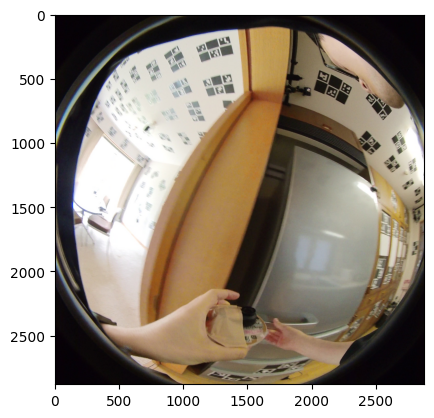

In [3]:
input_image = iio.imread("/secondary/brent/oners/left/0000000092.jpg")
plt.imshow(input_image)
plt.show()

In [4]:
%pdb
det_left, det_right = helper.look_for_hands(input_image)

Automatic pdb calling has been turned ON


/home/brent/miniconda/envs/py310/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
/home/brent/miniconda/envs/py310/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


downsampling_factor=1.4003067016601562
downsampling_factor=2.9339777628580728


In [5]:
if det_left is not None:
    print("Found left detections!")
    print(f"\t{det_left['verts'].shape=}")
else:
    print("No left detections!")

if det_right is not None:
    print("Found right detections!")
    print(f"\t{det_right['verts'].shape=}")
else:
    print("No right detections!")

Found left detections!
	det_left['verts'].shape=(1, 778, 3)
Found right detections!
	det_right['verts'].shape=(1, 778, 3)


In [6]:
h, w = input_image.shape[:2]

# Get (rgb, depth, mask).
outs = helper.render_detection(det_left, hand_index=0, h=h, w=w, focal_length=None)

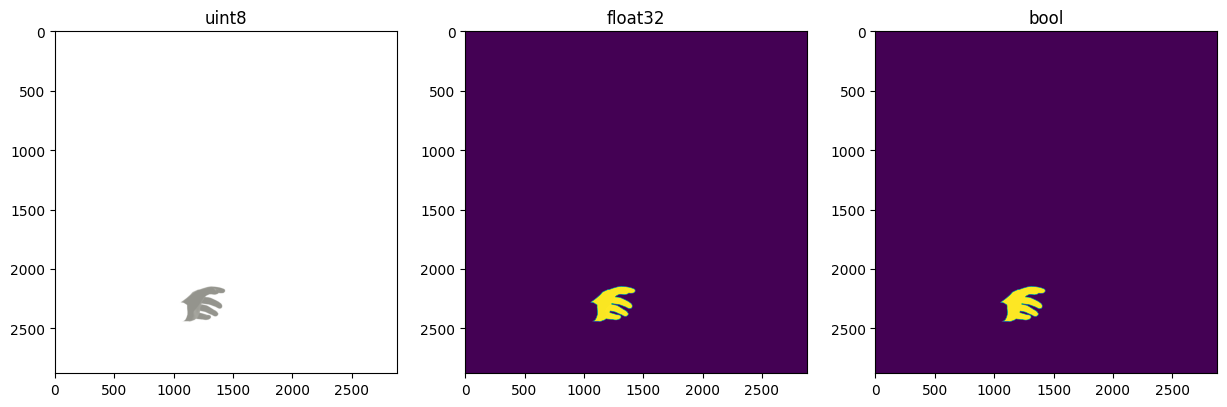

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(outs[0])
ax[0].set_title(str(outs[0].dtype))

ax[1].imshow(outs[1])
ax[1].set_title(str(outs[1].dtype))

ax[2].imshow(outs[2])
ax[2].set_title(str(outs[2].dtype))
fig.show()

0
0


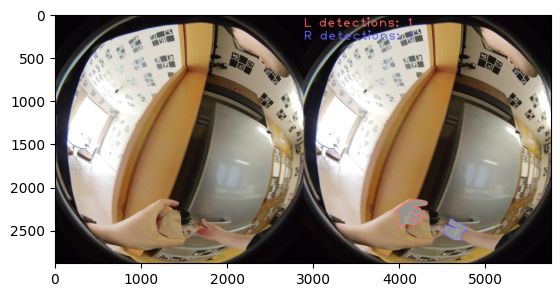

In [28]:
import numpy as np
import cv2
from scipy.ndimage import binary_dilation


def composite_detections(
    image: np.ndarray,
    detections: HandOutputsWrtCamera | None,
    border_color: tuple[int, int, int],
) -> np.ndarray:
    if detections is None:
        return image

    for index in range(detections["verts"].shape[0]):
        print(index)
        render_rgb, _, render_mask = helper.render_detection(
            detections, hand_index=0, h=h, w=w, focal_length=None
        )
        border_width = 15
        image = np.where(
            binary_dilation(
                render_mask, np.ones((border_width, border_width), dtype=bool)
            )[:, :, None],
            np.zeros_like(render_rgb) + np.array(border_color, dtype=np.uint8),
            image,
        )
        image = np.where(render_mask[:, :, None], render_rgb, image)

    return image


def put_text(
    image: np.ndarray,
    text: str,
    line_number: int,
    color: tuple[int, int, int],
    font_scale: float = 10.0,
) -> np.ndarray:
    image = image.copy()
    font = cv2.FONT_HERSHEY_PLAIN  # type: ignore
    cv2.putText(  # type: ignore
        image,
        text=text,
        org=(2, 1 + int(15 * font_scale * (line_number + 1))),
        fontFace=font,
        fontScale=font_scale,
        color=(0, 0, 0),
        thickness=int(font_scale),
        lineType=cv2.LINE_AA,  # type: ignore
    )
    cv2.putText(  # type: ignore
        image,
        text=text,
        org=(2, 1 + int(15 * font_scale * (line_number + 1))),
        fontFace=font,
        fontScale=font_scale,
        color=color,
        thickness=int(font_scale),
        lineType=cv2.LINE_AA,  # type: ignore
    )
    return image


composited = input_image
composited = composite_detections(composited, det_left, border_color=(255, 100, 100))
composited = composite_detections(composited, det_right, border_color=(100, 100, 255))

composited = put_text(
    composited,
    "L detections: " + ("0" if det_left is None else str(det_left["verts"].shape[0])),
    0,
    color=(255, 100, 100),
)
composited = put_text(
    composited,
    "R detections: " + ("0" if det_right is None else str(det_right["verts"].shape[0])),
    1,
    color=(100, 100, 255),
)

plt.imshow(np.concatenate([input_image, composited], axis=1))
plt.show()